# Deep Learning in Active Magnetic Regenerators

This Notebook presents the results for the application of Neural Networks in the prediction of the Cooling Capacity ($\dot{Q}_\mathrm{C}$ or $Qc$) and the Magnetization Power ($\dot{W}_\mathrm{m}$ or $Wm$) of Active Magnetic Regenerators. The Dataset consists in 532 points coming from numerical simulations.

### Importing the Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import joblib

mpl.style.use('default')
plt.rc('text',usetex = True)
plt.rc('font', family='serif',size = 12)

### Plotting Functions 

In [2]:
def plot_results(y_train,y_pred_train,y_test,y_pred_test,Obj):
    
    plt.figure()
    plt.plot(y_train,y_pred_train,'.',markersize = 7,color = '#1f77b4', mfc='none', label = 'Training Set')
    plt.plot(y_test,y_pred_test,'x' ,markersize = 5, color = '#2ca02c', mfc='none',label = 'Test Set',)
    
    if Obj == 'Qc':
        Aux = np.linspace(50,300)
        plt.plot(Aux,0.95*Aux,'k--')
        plt.plot(Aux,1.05*Aux,'k--')
        plt.text(140, 180, '$+ 5 \%$', fontsize=12)
        plt.text(150, 120, '$- 5 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{Q}_\mathrm{C}$ [W] - NN' )
        plt.xlabel(r' $\dot{Q}_\mathrm{C}$ [W] - Target')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Qc/Qc - NN.png', format = 'png', bbox_inches='tight') 
    
    elif Obj == 'Wm':
        Aux = np.linspace(10,60)
        plt.plot(Aux,0.95*Aux,'k--')
        plt.plot(Aux,1.05*Aux,'k--')
        plt.text(23, 17, '$- 5 \%$', fontsize=12)
        plt.text(19, 28, '$+ 5 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{W}_\mathrm{AMR,Mag}$ [W] - NN' )
        plt.xlabel(r' $\dot{W}_\mathrm{AMR,Mag}$ [W] - Target')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Wm/Wm - NN.png', format = 'png', bbox_inches='tight') 

### Reading the Input Parameteres 

The independent variable are the Width ($H$), Height ($H$) and Length ($L$) of the porous medium, the frequency ($f$) and mass flow rate ($mf$) of the Active Magnetic Regenerator, the Inlet Temperatures at the Hot ($Th$) and Cold ($Tc$) ends and the Applied Magnetic Field ($B$).

The dependent variables are the Cooling Capacity ($Qc$) and Magnetization Power ($Wm$).

In [3]:
Inputs = pd.read_excel('Data/Data_AMR.xlsx',index_col = 0, dtype=np.float32) # Input Data
X = Inputs[['W','H','f','mf','B','L','Th','Tc']]
y = Inputs[['Qc','Wm']]

### Train-Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)  

### Scaling the Features

In [6]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [7]:
joblib.dump(sc, 'Models/AMR_Scaler.pkl') 

['Models/AMR_Scaler.pkl']

### Building the Model

In [8]:
def Build(hp):
    
    #Grouping a stack of Layers in Model
    model = tf.keras.Sequential()
    model.add(BatchNormalization())
    # Adding the Layers
    # The number of layers, neurons in each one and activation functions are going to be tunned 
    for i in range(hp.Int('layers', 0, 2)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 1, 301, step=3),
                                        activation=hp.Choice('act_' + str(i), ['relu','sigmoid','selu'])))
        #model.add(Dropout(0.05))
        #Applying a Batch Normalization Layer after Dense Layer
        model.add(BatchNormalization())

        
    # Adding a final Layer 
    model.add(tf.keras.layers.Dense(1, activation='selu'))
    
    # Compiling the Model with the Adam optimization algorithm
    model.compile(optimizer=Adam(),
                  loss="mean_squared_error",
                  #metrics=['accuracy']
                  metrics = ['mean_squared_error']
                 )
    return model

### Batch Optimization

Overriding run_trial in MyTuner (https://kegui.medium.com/how-to-tune-the-number-of-epochs-and-batch-size-in-keras-tuner-c2ab2d40878d)

In [9]:
class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 1, 501, step=5)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

### Defining the Tuner

In [10]:
def NeuNet(X_train,y_train,max_epochs,Obj):
    
    # Defining the Tuner
    tuner = MyTuner(Build,
                    objective = 'val_loss',
                    max_epochs = max_epochs,
                    directory='KT_Dir',
                    project_name='KT_Hyperband_' + Obj,
                    executions_per_trial = 1,   
    )
    
    # Hyperparameter Optimization
    tuner.search(X_train,
                 y_train[Obj],
                 epochs=max_epochs,
                 callbacks=[EarlyStopping('val_loss', patience=5)],
                 verbose=1,
                 validation_split=0.2)
    
  
    # Trainning the Best Model
    best_model = tuner.get_best_models()[0]
    best_model.build(X_train.shape)
    best_model.fit(X_train,
                   y_train[Obj], 
                   epochs=max_epochs,
                   batch_size=tuner.get_best_hyperparameters(num_trials=1)[0].get('batch_size')
    )
    best_model.summary()
    
    # Saving the Model
    best_model.save('Models/'+Obj+'/'+ Obj +'_NN.h5')
    
     #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], best_model.predict(X_train))))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], best_model.predict(X_test)))) 

    # Plotting the Results
    plot_results(y_train[Obj], best_model.predict(X_train), y_test[Obj], best_model.predict(X_test), Obj) 

### Defining a Test Function

In [11]:
def Test(X_train,y_train,Obj, Scal):
    
    Model = load_model('Models/'+Obj+'/'+ Obj +'_NN.h5', compile = False)
    Model.summary()
    #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], Model.predict(Scal.transform(X_train)))))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], Model.predict(Scal.transform(X_test))))) 

    # Plotting the Results
    plot_results(y_train[Obj], Model.predict(Scal.transform(X_train)), y_test[Obj], Model.predict(Scal.transform(X_test)), Obj) 

### Training the Models

Trial 2057 Complete [00h 05m 17s]
val_loss: 11769.46875

Best val_loss So Far: 72.62679290771484
Total elapsed time: 03h 20m 03s
INFO:tensorflow:Oracle triggered exit
Epoch 1/1000
27/27 [==============================] - 0s 814us/step - loss: 237.7986 - mean_squared_error: 237.7986
Epoch 2/1000
27/27 [==============================] - 0s 777us/step - loss: 292.2129 - mean_squared_error: 292.2129
Epoch 3/1000
27/27 [==============================] - 0s 740us/step - loss: 210.3949 - mean_squared_error: 210.3949
Epoch 4/1000
27/27 [==============================] - 0s 888us/step - loss: 239.2367 - mean_squared_error: 239.2367
Epoch 5/1000
27/27 [==============================] - 0s 889us/step - loss: 185.4062 - mean_squared_error: 185.4062
Epoch 6/1000
27/27 [==============================] - 0s 851us/step - loss: 210.3228 - mean_squared_error: 210.3228
Epoch 7/1000
27/27 [==============================] - 0s 740us/step - loss: 212.3007 - mean_squared_error: 212.3007
Epoch 8/1000
27/27 [=

27/27 [==============================] - 0s 888us/step - loss: 214.1179 - mean_squared_error: 214.1179
Epoch 70/1000
27/27 [==============================] - 0s 962us/step - loss: 190.3734 - mean_squared_error: 190.3734
Epoch 71/1000
27/27 [==============================] - 0s 851us/step - loss: 167.9076 - mean_squared_error: 167.9076
Epoch 72/1000
27/27 [==============================] - 0s 851us/step - loss: 216.6353 - mean_squared_error: 216.6353
Epoch 73/1000
27/27 [==============================] - 0s 851us/step - loss: 165.6454 - mean_squared_error: 165.6454
Epoch 74/1000
27/27 [==============================] - 0s 851us/step - loss: 223.7619 - mean_squared_error: 223.7619
Epoch 75/1000
27/27 [==============================] - 0s 777us/step - loss: 251.9037 - mean_squared_error: 251.9037
Epoch 76/1000
27/27 [==============================] - 0s 777us/step - loss: 198.7685 - mean_squared_error: 198.7685
Epoch 77/1000
27/27 [==============================] - 0s 962us/step - loss: 2

27/27 [==============================] - 0s 888us/step - loss: 215.2974 - mean_squared_error: 215.2974
Epoch 139/1000
27/27 [==============================] - 0s 925us/step - loss: 195.2359 - mean_squared_error: 195.2359
Epoch 140/1000
27/27 [==============================] - 0s 888us/step - loss: 156.6379 - mean_squared_error: 156.6379
Epoch 141/1000
27/27 [==============================] - 0s 851us/step - loss: 248.3643 - mean_squared_error: 248.3643
Epoch 142/1000
27/27 [==============================] - 0s 888us/step - loss: 138.6544 - mean_squared_error: 138.6544
Epoch 143/1000
27/27 [==============================] - 0s 814us/step - loss: 172.0820 - mean_squared_error: 172.0820
Epoch 144/1000
27/27 [==============================] - 0s 814us/step - loss: 264.0583 - mean_squared_error: 264.0583
Epoch 145/1000
27/27 [==============================] - 0s 777us/step - loss: 191.7424 - mean_squared_error: 191.7424
Epoch 146/1000
27/27 [==============================] - 0s 814us/step -

27/27 [==============================] - 0s 888us/step - loss: 195.0461 - mean_squared_error: 195.0461
Epoch 208/1000
27/27 [==============================] - 0s 888us/step - loss: 183.9552 - mean_squared_error: 183.9552
Epoch 209/1000
27/27 [==============================] - 0s 814us/step - loss: 213.0883 - mean_squared_error: 213.0883
Epoch 210/1000
27/27 [==============================] - 0s 962us/step - loss: 225.2269 - mean_squared_error: 225.2269
Epoch 211/1000
27/27 [==============================] - 0s 999us/step - loss: 176.8554 - mean_squared_error: 176.8554
Epoch 212/1000
27/27 [==============================] - 0s 925us/step - loss: 213.8821 - mean_squared_error: 213.8821
Epoch 213/1000
27/27 [==============================] - 0s 925us/step - loss: 239.4379 - mean_squared_error: 239.4379
Epoch 214/1000
27/27 [==============================] - 0s 925us/step - loss: 179.9296 - mean_squared_error: 179.9296
Epoch 215/1000
27/27 [==============================] - 0s 925us/step -

27/27 [==============================] - 0s 851us/step - loss: 181.1947 - mean_squared_error: 181.1947
Epoch 277/1000
27/27 [==============================] - 0s 851us/step - loss: 284.0830 - mean_squared_error: 284.0830
Epoch 278/1000
27/27 [==============================] - 0s 814us/step - loss: 148.4555 - mean_squared_error: 148.4555
Epoch 279/1000
27/27 [==============================] - 0s 888us/step - loss: 209.3006 - mean_squared_error: 209.3006
Epoch 280/1000
27/27 [==============================] - 0s 814us/step - loss: 232.8052 - mean_squared_error: 232.8052
Epoch 281/1000
27/27 [==============================] - 0s 925us/step - loss: 211.7072 - mean_squared_error: 211.7072
Epoch 282/1000
27/27 [==============================] - 0s 888us/step - loss: 145.4983 - mean_squared_error: 145.4983
Epoch 283/1000
27/27 [==============================] - 0s 888us/step - loss: 181.8562 - mean_squared_error: 181.8562
Epoch 284/1000
27/27 [==============================] - 0s 1ms/step - l

27/27 [==============================] - 0s 888us/step - loss: 210.4988 - mean_squared_error: 210.4988
Epoch 346/1000
27/27 [==============================] - 0s 925us/step - loss: 167.6630 - mean_squared_error: 167.6630
Epoch 347/1000
27/27 [==============================] - 0s 925us/step - loss: 161.4636 - mean_squared_error: 161.4636
Epoch 348/1000
27/27 [==============================] - 0s 925us/step - loss: 202.1381 - mean_squared_error: 202.1381
Epoch 349/1000
27/27 [==============================] - 0s 925us/step - loss: 200.6657 - mean_squared_error: 200.6657
Epoch 350/1000
27/27 [==============================] - 0s 851us/step - loss: 156.1863 - mean_squared_error: 156.1863
Epoch 351/1000
27/27 [==============================] - 0s 814us/step - loss: 163.2901 - mean_squared_error: 163.2901
Epoch 352/1000
27/27 [==============================] - 0s 740us/step - loss: 199.2491 - mean_squared_error: 199.2491
Epoch 353/1000
27/27 [==============================] - 0s 740us/step -

27/27 [==============================] - 0s 888us/step - loss: 216.8317 - mean_squared_error: 216.8317
Epoch 415/1000
27/27 [==============================] - 0s 814us/step - loss: 176.1511 - mean_squared_error: 176.1511
Epoch 416/1000
27/27 [==============================] - 0s 888us/step - loss: 213.8554 - mean_squared_error: 213.8554
Epoch 417/1000
27/27 [==============================] - 0s 814us/step - loss: 253.5789 - mean_squared_error: 253.5789
Epoch 418/1000
27/27 [==============================] - 0s 777us/step - loss: 178.3590 - mean_squared_error: 178.3590
Epoch 419/1000
27/27 [==============================] - 0s 740us/step - loss: 188.3047 - mean_squared_error: 188.3047
Epoch 420/1000
27/27 [==============================] - 0s 740us/step - loss: 216.3967 - mean_squared_error: 216.3967
Epoch 421/1000
27/27 [==============================] - 0s 962us/step - loss: 219.8961 - mean_squared_error: 219.8961
Epoch 422/1000
27/27 [==============================] - 0s 888us/step -

27/27 [==============================] - 0s 999us/step - loss: 162.8698 - mean_squared_error: 162.8698
Epoch 484/1000
27/27 [==============================] - 0s 999us/step - loss: 238.4362 - mean_squared_error: 238.4362
Epoch 485/1000
27/27 [==============================] - 0s 777us/step - loss: 164.0744 - mean_squared_error: 164.0744
Epoch 486/1000
27/27 [==============================] - 0s 888us/step - loss: 165.3196 - mean_squared_error: 165.3196
Epoch 487/1000
27/27 [==============================] - 0s 1ms/step - loss: 205.5470 - mean_squared_error: 205.5470
Epoch 488/1000
27/27 [==============================] - 0s 1ms/step - loss: 141.1686 - mean_squared_error: 141.1686
Epoch 489/1000
27/27 [==============================] - 0s 1ms/step - loss: 156.6552 - mean_squared_error: 156.6552
Epoch 490/1000
27/27 [==============================] - 0s 814us/step - loss: 254.1827 - mean_squared_error: 254.1827
Epoch 491/1000
27/27 [==============================] - 0s 888us/step - loss:

27/27 [==============================] - 0s 925us/step - loss: 262.0478 - mean_squared_error: 262.0478
Epoch 553/1000
27/27 [==============================] - 0s 962us/step - loss: 178.4419 - mean_squared_error: 178.4419
Epoch 554/1000
27/27 [==============================] - 0s 851us/step - loss: 215.9923 - mean_squared_error: 215.9923
Epoch 555/1000
27/27 [==============================] - 0s 962us/step - loss: 215.4922 - mean_squared_error: 215.4922
Epoch 556/1000
27/27 [==============================] - 0s 962us/step - loss: 145.9371 - mean_squared_error: 145.9371
Epoch 557/1000
27/27 [==============================] - 0s 888us/step - loss: 234.1073 - mean_squared_error: 234.1073
Epoch 558/1000
27/27 [==============================] - 0s 814us/step - loss: 165.2967 - mean_squared_error: 165.2967
Epoch 559/1000
27/27 [==============================] - 0s 777us/step - loss: 142.4570 - mean_squared_error: 142.4570
Epoch 560/1000
27/27 [==============================] - 0s 814us/step -

27/27 [==============================] - 0s 814us/step - loss: 155.8496 - mean_squared_error: 155.8496
Epoch 622/1000
27/27 [==============================] - 0s 999us/step - loss: 135.2319 - mean_squared_error: 135.2319
Epoch 623/1000
27/27 [==============================] - 0s 926us/step - loss: 155.0953 - mean_squared_error: 155.0953
Epoch 624/1000
27/27 [==============================] - 0s 925us/step - loss: 152.7188 - mean_squared_error: 152.7188
Epoch 625/1000
27/27 [==============================] - 0s 925us/step - loss: 186.8685 - mean_squared_error: 186.8685
Epoch 626/1000
27/27 [==============================] - 0s 925us/step - loss: 189.5031 - mean_squared_error: 189.5031
Epoch 627/1000
27/27 [==============================] - 0s 925us/step - loss: 180.6279 - mean_squared_error: 180.6279
Epoch 628/1000
27/27 [==============================] - 0s 851us/step - loss: 214.9075 - mean_squared_error: 214.9075
Epoch 629/1000
27/27 [==============================] - 0s 999us/step -

27/27 [==============================] - 0s 925us/step - loss: 167.3949 - mean_squared_error: 167.3949
Epoch 691/1000
27/27 [==============================] - 0s 925us/step - loss: 134.7249 - mean_squared_error: 134.7249
Epoch 692/1000
27/27 [==============================] - 0s 962us/step - loss: 163.6382 - mean_squared_error: 163.6382
Epoch 693/1000
27/27 [==============================] - 0s 925us/step - loss: 105.4371 - mean_squared_error: 105.4371
Epoch 694/1000
27/27 [==============================] - 0s 814us/step - loss: 191.3737 - mean_squared_error: 191.3737
Epoch 695/1000
27/27 [==============================] - 0s 925us/step - loss: 132.4160 - mean_squared_error: 132.4160
Epoch 696/1000
27/27 [==============================] - 0s 962us/step - loss: 155.5797 - mean_squared_error: 155.5797
Epoch 697/1000
27/27 [==============================] - 0s 888us/step - loss: 180.2409 - mean_squared_error: 180.2409
Epoch 698/1000
27/27 [==============================] - 0s 888us/step -

27/27 [==============================] - 0s 851us/step - loss: 177.6519 - mean_squared_error: 177.6519
Epoch 760/1000
27/27 [==============================] - 0s 740us/step - loss: 189.3081 - mean_squared_error: 189.3081
Epoch 761/1000
27/27 [==============================] - 0s 814us/step - loss: 193.7289 - mean_squared_error: 193.7289
Epoch 762/1000
27/27 [==============================] - 0s 925us/step - loss: 183.6809 - mean_squared_error: 183.6809
Epoch 763/1000
27/27 [==============================] - 0s 814us/step - loss: 190.5757 - mean_squared_error: 190.5757
Epoch 764/1000
27/27 [==============================] - 0s 888us/step - loss: 175.4723 - mean_squared_error: 175.4723
Epoch 765/1000
27/27 [==============================] - 0s 851us/step - loss: 164.7022 - mean_squared_error: 164.7022
Epoch 766/1000
27/27 [==============================] - 0s 851us/step - loss: 162.6706 - mean_squared_error: 162.6706
Epoch 767/1000
27/27 [==============================] - 0s 851us/step -

27/27 [==============================] - 0s 740us/step - loss: 173.5274 - mean_squared_error: 173.5274
Epoch 829/1000
27/27 [==============================] - 0s 851us/step - loss: 170.4216 - mean_squared_error: 170.4216
Epoch 830/1000
27/27 [==============================] - 0s 777us/step - loss: 173.5392 - mean_squared_error: 173.5392
Epoch 831/1000
27/27 [==============================] - 0s 888us/step - loss: 195.3519 - mean_squared_error: 195.3519
Epoch 832/1000
27/27 [==============================] - 0s 740us/step - loss: 178.4554 - mean_squared_error: 178.4554
Epoch 833/1000
27/27 [==============================] - 0s 777us/step - loss: 145.1405 - mean_squared_error: 145.1405
Epoch 834/1000
27/27 [==============================] - 0s 814us/step - loss: 214.3303 - mean_squared_error: 214.3303
Epoch 835/1000
27/27 [==============================] - 0s 999us/step - loss: 171.6789 - mean_squared_error: 171.6789
Epoch 836/1000
27/27 [==============================] - 0s 888us/step -

27/27 [==============================] - 0s 814us/step - loss: 281.9213 - mean_squared_error: 281.9213
Epoch 898/1000
27/27 [==============================] - 0s 962us/step - loss: 133.6642 - mean_squared_error: 133.6642
Epoch 899/1000
27/27 [==============================] - 0s 1ms/step - loss: 159.8750 - mean_squared_error: 159.8750
Epoch 900/1000
27/27 [==============================] - 0s 999us/step - loss: 161.7591 - mean_squared_error: 161.7591
Epoch 901/1000
27/27 [==============================] - 0s 814us/step - loss: 216.3400 - mean_squared_error: 216.3400
Epoch 902/1000
27/27 [==============================] - 0s 888us/step - loss: 171.3123 - mean_squared_error: 171.3123
Epoch 903/1000
27/27 [==============================] - 0s 851us/step - loss: 141.8691 - mean_squared_error: 141.8691
Epoch 904/1000
27/27 [==============================] - 0s 851us/step - loss: 193.7997 - mean_squared_error: 193.7997
Epoch 905/1000
27/27 [==============================] - 0s 851us/step - l

27/27 [==============================] - 0s 851us/step - loss: 144.5775 - mean_squared_error: 144.5775
Epoch 967/1000
27/27 [==============================] - 0s 814us/step - loss: 209.9647 - mean_squared_error: 209.9647
Epoch 968/1000
27/27 [==============================] - 0s 814us/step - loss: 190.7638 - mean_squared_error: 190.7638
Epoch 969/1000
27/27 [==============================] - 0s 777us/step - loss: 179.2303 - mean_squared_error: 179.2303
Epoch 970/1000
27/27 [==============================] - 0s 777us/step - loss: 166.8452 - mean_squared_error: 166.8452
Epoch 971/1000
27/27 [==============================] - 0s 851us/step - loss: 216.9380 - mean_squared_error: 216.9380
Epoch 972/1000
27/27 [==============================] - 0s 962us/step - loss: 144.7046 - mean_squared_error: 144.7046
Epoch 973/1000
27/27 [==============================] - 0s 851us/step - loss: 203.7196 - mean_squared_error: 203.7196
Epoch 974/1000
27/27 [==============================] - 0s 888us/step -

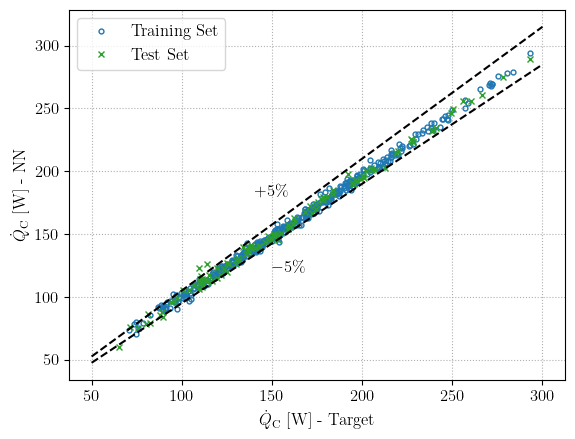

In [12]:
NeuNet(X_train,y_train,1000,'Qc')

Trial 2074 Complete [00h 00m 12s]
val_loss: 71.72832489013672

Best val_loss So Far: 0.4621712267398834
Total elapsed time: 02h 27m 05s
INFO:tensorflow:Oracle triggered exit
Epoch 1/1000
11/11 [==============================] - 0s 999us/step - loss: 3.1712 - mean_squared_error: 3.1712
Epoch 2/1000
11/11 [==============================] - 0s 999us/step - loss: 2.9246 - mean_squared_error: 2.9246
Epoch 3/1000
11/11 [==============================] - 0s 999us/step - loss: 3.1804 - mean_squared_error: 3.1804
Epoch 4/1000
11/11 [==============================] - 0s 1ms/step - loss: 1.6582 - mean_squared_error: 1.6582
Epoch 5/1000
11/11 [==============================] - 0s 999us/step - loss: 3.2795 - mean_squared_error: 3.2795
Epoch 6/1000
11/11 [==============================] - 0s 999us/step - loss: 4.5255 - mean_squared_error: 4.5255
Epoch 7/1000
11/11 [==============================] - 0s 999us/step - loss: 2.4967 - mean_squared_error: 2.4967
Epoch 8/1000
11/11 [========================

11/11 [==============================] - 0s 999us/step - loss: 2.2909 - mean_squared_error: 2.2909
Epoch 73/1000
11/11 [==============================] - 0s 909us/step - loss: 2.7333 - mean_squared_error: 2.7333
Epoch 74/1000
11/11 [==============================] - 0s 908us/step - loss: 5.3298 - mean_squared_error: 5.3298
Epoch 75/1000
11/11 [==============================] - 0s 999us/step - loss: 2.8793 - mean_squared_error: 2.8793
Epoch 76/1000
11/11 [==============================] - 0s 1ms/step - loss: 3.3974 - mean_squared_error: 3.3974
Epoch 77/1000
11/11 [==============================] - 0s 909us/step - loss: 2.1089 - mean_squared_error: 2.1089
Epoch 78/1000
11/11 [==============================] - 0s 1ms/step - loss: 1.6807 - mean_squared_error: 1.6807
Epoch 79/1000
11/11 [==============================] - 0s 1ms/step - loss: 1.7797 - mean_squared_error: 1.7797
Epoch 80/1000
11/11 [==============================] - 0s 999us/step - loss: 3.1272 - mean_squared_error: 3.1272
Epo

11/11 [==============================] - 0s 909us/step - loss: 2.9848 - mean_squared_error: 2.9848
Epoch 145/1000
11/11 [==============================] - 0s 909us/step - loss: 3.3231 - mean_squared_error: 3.3231
Epoch 146/1000
11/11 [==============================] - 0s 909us/step - loss: 3.4252 - mean_squared_error: 3.4252
Epoch 147/1000
11/11 [==============================] - 0s 999us/step - loss: 1.5708 - mean_squared_error: 1.5708
Epoch 148/1000
11/11 [==============================] - 0s 908us/step - loss: 5.1102 - mean_squared_error: 5.1102
Epoch 149/1000
11/11 [==============================] - 0s 908us/step - loss: 2.7429 - mean_squared_error: 2.7429
Epoch 150/1000
11/11 [==============================] - 0s 909us/step - loss: 4.0699 - mean_squared_error: 4.0699
Epoch 151/1000
11/11 [==============================] - 0s 1000us/step - loss: 2.6815 - mean_squared_error: 2.6815
Epoch 152/1000
11/11 [==============================] - 0s 908us/step - loss: 3.3518 - mean_squared_er

11/11 [==============================] - 0s 909us/step - loss: 2.2349 - mean_squared_error: 2.2349
Epoch 217/1000
11/11 [==============================] - 0s 909us/step - loss: 4.0457 - mean_squared_error: 4.0457
Epoch 218/1000
11/11 [==============================] - 0s 908us/step - loss: 2.3996 - mean_squared_error: 2.3996
Epoch 219/1000
11/11 [==============================] - 0s 908us/step - loss: 2.3127 - mean_squared_error: 2.3127
Epoch 220/1000
11/11 [==============================] - 0s 909us/step - loss: 5.2358 - mean_squared_error: 5.2358
Epoch 221/1000
11/11 [==============================] - 0s 909us/step - loss: 1.6316 - mean_squared_error: 1.6316
Epoch 222/1000
11/11 [==============================] - 0s 908us/step - loss: 5.6180 - mean_squared_error: 5.6180
Epoch 223/1000
11/11 [==============================] - 0s 909us/step - loss: 3.4001 - mean_squared_error: 3.4001
Epoch 224/1000
11/11 [==============================] - 0s 909us/step - loss: 3.3011 - mean_squared_err

11/11 [==============================] - 0s 909us/step - loss: 2.5886 - mean_squared_error: 2.5886
Epoch 289/1000
11/11 [==============================] - 0s 909us/step - loss: 2.3706 - mean_squared_error: 2.3706
Epoch 290/1000
11/11 [==============================] - 0s 910us/step - loss: 2.6167 - mean_squared_error: 2.6167
Epoch 291/1000
11/11 [==============================] - 0s 999us/step - loss: 2.1944 - mean_squared_error: 2.1944
Epoch 292/1000
11/11 [==============================] - 0s 909us/step - loss: 1.7540 - mean_squared_error: 1.7540
Epoch 293/1000
11/11 [==============================] - 0s 909us/step - loss: 3.4911 - mean_squared_error: 3.4911
Epoch 294/1000
11/11 [==============================] - 0s 909us/step - loss: 1.9438 - mean_squared_error: 1.9438
Epoch 295/1000
11/11 [==============================] - 0s 909us/step - loss: 3.1960 - mean_squared_error: 3.1960
Epoch 296/1000
11/11 [==============================] - 0s 1ms/step - loss: 3.6421 - mean_squared_error

Epoch 360/1000
11/11 [==============================] - 0s 1ms/step - loss: 2.5193 - mean_squared_error: 2.5193
Epoch 361/1000
11/11 [==============================] - 0s 999us/step - loss: 4.4082 - mean_squared_error: 4.4082
Epoch 362/1000
11/11 [==============================] - 0s 909us/step - loss: 2.3642 - mean_squared_error: 2.3642
Epoch 363/1000
11/11 [==============================] - 0s 909us/step - loss: 2.7445 - mean_squared_error: 2.7445
Epoch 364/1000
11/11 [==============================] - 0s 1ms/step - loss: 2.5374 - mean_squared_error: 2.5374
Epoch 365/1000
11/11 [==============================] - 0s 999us/step - loss: 2.6469 - mean_squared_error: 2.6469
Epoch 366/1000
11/11 [==============================] - 0s 999us/step - loss: 3.8649 - mean_squared_error: 3.8649
Epoch 367/1000
11/11 [==============================] - 0s 909us/step - loss: 4.7688 - mean_squared_error: 4.7688
Epoch 368/1000
11/11 [==============================] - 0s 909us/step - loss: 1.8655 - mean_

Epoch 432/1000
11/11 [==============================] - 0s 999us/step - loss: 2.8829 - mean_squared_error: 2.8829
Epoch 433/1000
11/11 [==============================] - 0s 908us/step - loss: 2.4492 - mean_squared_error: 2.4492
Epoch 434/1000
11/11 [==============================] - 0s 908us/step - loss: 2.9050 - mean_squared_error: 2.9050
Epoch 435/1000
11/11 [==============================] - 0s 1ms/step - loss: 1.8923 - mean_squared_error: 1.8923
Epoch 436/1000
11/11 [==============================] - 0s 999us/step - loss: 3.4967 - mean_squared_error: 3.4967
Epoch 437/1000
11/11 [==============================] - 0s 1000us/step - loss: 2.1250 - mean_squared_error: 2.1250
Epoch 438/1000
11/11 [==============================] - 0s 999us/step - loss: 4.0445 - mean_squared_error: 4.0445
Epoch 439/1000
11/11 [==============================] - 0s 909us/step - loss: 2.9956 - mean_squared_error: 2.9956
Epoch 440/1000
11/11 [==============================] - 0s 909us/step - loss: 2.7763 - me

11/11 [==============================] - 0s 999us/step - loss: 2.5965 - mean_squared_error: 2.5965
Epoch 504/1000
11/11 [==============================] - 0s 1ms/step - loss: 1.8403 - mean_squared_error: 1.8403
Epoch 505/1000
11/11 [==============================] - 0s 999us/step - loss: 1.7427 - mean_squared_error: 1.7427
Epoch 506/1000
11/11 [==============================] - 0s 909us/step - loss: 1.8586 - mean_squared_error: 1.8586
Epoch 507/1000
11/11 [==============================] - 0s 909us/step - loss: 2.8620 - mean_squared_error: 2.8620
Epoch 508/1000
11/11 [==============================] - 0s 909us/step - loss: 2.5005 - mean_squared_error: 2.5005
Epoch 509/1000
11/11 [==============================] - 0s 1000us/step - loss: 3.6199 - mean_squared_error: 3.6199
Epoch 510/1000
11/11 [==============================] - 0s 909us/step - loss: 3.2755 - mean_squared_error: 3.2755
Epoch 511/1000
11/11 [==============================] - 0s 999us/step - loss: 1.7961 - mean_squared_erro

11/11 [==============================] - 0s 943us/step - loss: 3.1439 - mean_squared_error: 3.1439
Epoch 576/1000
11/11 [==============================] - 0s 909us/step - loss: 4.0294 - mean_squared_error: 4.0294
Epoch 577/1000
11/11 [==============================] - 0s 908us/step - loss: 2.5047 - mean_squared_error: 2.5047
Epoch 578/1000
11/11 [==============================] - 0s 999us/step - loss: 2.4674 - mean_squared_error: 2.4674
Epoch 579/1000
11/11 [==============================] - 0s 909us/step - loss: 2.5097 - mean_squared_error: 2.5097
Epoch 580/1000
11/11 [==============================] - 0s 999us/step - loss: 3.0174 - mean_squared_error: 3.0174
Epoch 581/1000
11/11 [==============================] - 0s 910us/step - loss: 4.0132 - mean_squared_error: 4.0132
Epoch 582/1000
11/11 [==============================] - 0s 1000us/step - loss: 5.4206 - mean_squared_error: 5.4206
Epoch 583/1000
11/11 [==============================] - 0s 909us/step - loss: 1.1857 - mean_squared_er

11/11 [==============================] - 0s 999us/step - loss: 2.8696 - mean_squared_error: 2.8696
Epoch 647/1000
11/11 [==============================] - 0s 999us/step - loss: 4.4289 - mean_squared_error: 4.4289
Epoch 648/1000
11/11 [==============================] - 0s 908us/step - loss: 3.2496 - mean_squared_error: 3.2496
Epoch 649/1000
11/11 [==============================] - 0s 908us/step - loss: 1.3468 - mean_squared_error: 1.3468
Epoch 650/1000
11/11 [==============================] - 0s 908us/step - loss: 2.5339 - mean_squared_error: 2.5339
Epoch 651/1000
11/11 [==============================] - 0s 999us/step - loss: 2.3450 - mean_squared_error: 2.3450
Epoch 652/1000
11/11 [==============================] - 0s 909us/step - loss: 2.5278 - mean_squared_error: 2.5278
Epoch 653/1000
11/11 [==============================] - 0s 909us/step - loss: 2.5159 - mean_squared_error: 2.5159
Epoch 654/1000
11/11 [==============================] - 0s 909us/step - loss: 1.7846 - mean_squared_err

11/11 [==============================] - 0s 909us/step - loss: 3.0897 - mean_squared_error: 3.0897
Epoch 719/1000
11/11 [==============================] - 0s 1ms/step - loss: 1.4415 - mean_squared_error: 1.4415
Epoch 720/1000
11/11 [==============================] - 0s 1ms/step - loss: 2.0179 - mean_squared_error: 2.0179
Epoch 721/1000
11/11 [==============================] - 0s 999us/step - loss: 2.9296 - mean_squared_error: 2.9296
Epoch 722/1000
11/11 [==============================] - 0s 998us/step - loss: 3.1609 - mean_squared_error: 3.1609
Epoch 723/1000
11/11 [==============================] - 0s 908us/step - loss: 2.1998 - mean_squared_error: 2.1998
Epoch 724/1000
11/11 [==============================] - 0s 909us/step - loss: 2.5762 - mean_squared_error: 2.5762
Epoch 725/1000
11/11 [==============================] - 0s 908us/step - loss: 2.9044 - mean_squared_error: 2.9044
Epoch 726/1000
11/11 [==============================] - 0s 999us/step - loss: 4.1221 - mean_squared_error: 

11/11 [==============================] - 0s 909us/step - loss: 2.4517 - mean_squared_error: 2.4517
Epoch 791/1000
11/11 [==============================] - 0s 999us/step - loss: 2.4342 - mean_squared_error: 2.4342
Epoch 792/1000
11/11 [==============================] - 0s 1000us/step - loss: 2.6036 - mean_squared_error: 2.6036
Epoch 793/1000
11/11 [==============================] - 0s 1000us/step - loss: 2.1092 - mean_squared_error: 2.1092
Epoch 794/1000
11/11 [==============================] - 0s 1000us/step - loss: 2.8961 - mean_squared_error: 2.8961
Epoch 795/1000
11/11 [==============================] - 0s 999us/step - loss: 1.9844 - mean_squared_error: 1.9844
Epoch 796/1000
11/11 [==============================] - 0s 1ms/step - loss: 1.4901 - mean_squared_error: 1.4901
Epoch 797/1000
11/11 [==============================] - 0s 999us/step - loss: 3.8784 - mean_squared_error: 3.8784
Epoch 798/1000
11/11 [==============================] - 0s 1000us/step - loss: 2.0695 - mean_squared_e

11/11 [==============================] - 0s 909us/step - loss: 3.0195 - mean_squared_error: 3.0195
Epoch 863/1000
11/11 [==============================] - 0s 999us/step - loss: 3.0699 - mean_squared_error: 3.0699
Epoch 864/1000
11/11 [==============================] - 0s 909us/step - loss: 2.0448 - mean_squared_error: 2.0448
Epoch 865/1000
11/11 [==============================] - 0s 999us/step - loss: 5.2622 - mean_squared_error: 5.2622
Epoch 866/1000
11/11 [==============================] - 0s 919us/step - loss: 3.2992 - mean_squared_error: 3.2992
Epoch 867/1000
11/11 [==============================] - 0s 908us/step - loss: 2.0410 - mean_squared_error: 2.0410
Epoch 868/1000
11/11 [==============================] - 0s 908us/step - loss: 2.6092 - mean_squared_error: 2.6092
Epoch 869/1000
11/11 [==============================] - 0s 999us/step - loss: 3.6570 - mean_squared_error: 3.6570
Epoch 870/1000
11/11 [==============================] - 0s 909us/step - loss: 3.4589 - mean_squared_err

11/11 [==============================] - 0s 908us/step - loss: 2.7082 - mean_squared_error: 2.7082
Epoch 935/1000
11/11 [==============================] - 0s 999us/step - loss: 2.8923 - mean_squared_error: 2.8923
Epoch 936/1000
11/11 [==============================] - 0s 909us/step - loss: 1.4282 - mean_squared_error: 1.4282
Epoch 937/1000
11/11 [==============================] - 0s 910us/step - loss: 2.2716 - mean_squared_error: 2.2716
Epoch 938/1000
11/11 [==============================] - 0s 909us/step - loss: 2.9506 - mean_squared_error: 2.9506
Epoch 939/1000
11/11 [==============================] - 0s 999us/step - loss: 2.2781 - mean_squared_error: 2.2781
Epoch 940/1000
11/11 [==============================] - 0s 998us/step - loss: 1.4584 - mean_squared_error: 1.4584
Epoch 941/1000
11/11 [==============================] - 0s 999us/step - loss: 2.3064 - mean_squared_error: 2.3064
Epoch 942/1000
11/11 [==============================] - 0s 999us/step - loss: 2.6588 - mean_squared_err

dense_1 (Dense)              (None, 1)                 296       
Total params: 4,163
Trainable params: 3,557
Non-trainable params: 606
_________________________________________________________________
The coefficient of determination for Wm Training Set using Neural Networks is 0.9971362917225965
The coefficient of determination for Wm Test Set using Neural Networks is 0.9960407107071586


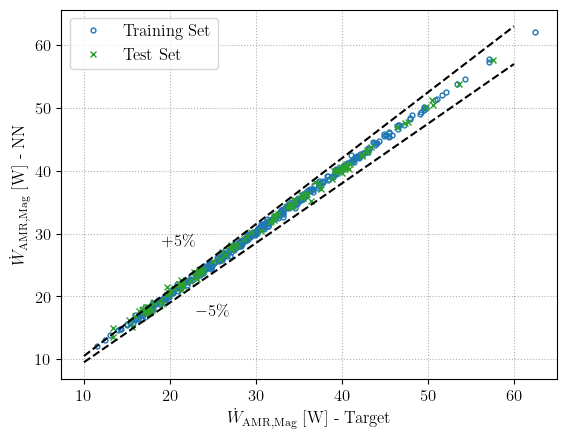

In [13]:
NeuNet(X_train,y_train,1000,'Wm')

### Testing the Models

### Reading the Input Parameteres 

In [17]:
Inputs = pd.read_excel('Data/Data_AMR.xlsx',index_col = 0, dtype=np.float32) # Input Data
X = Inputs[['W','H','f','mf','B','L','Th','Tc']]
y = Inputs[['Qc','Wm']]

### Train-Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)  

### Scaling the Features

In [19]:
Scaller = joblib.load('Models/AMR_Scaler.pkl')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 8)                 32        
_________________________________________________________________
dense (Dense)                (None, 232)               2088      
_________________________________________________________________
batch_normalization_1 (Batch (None, 232)               928       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 233       
Total params: 3,281
Trainable params: 2,801
Non-trainable params: 480
_________________________________________________________________
The coefficient of determination for Qc Training Set using Neural Networks is 0.9940284104323182
The coefficient of determination for Qc Test Set using Neural Networks is 0.9938407890171023


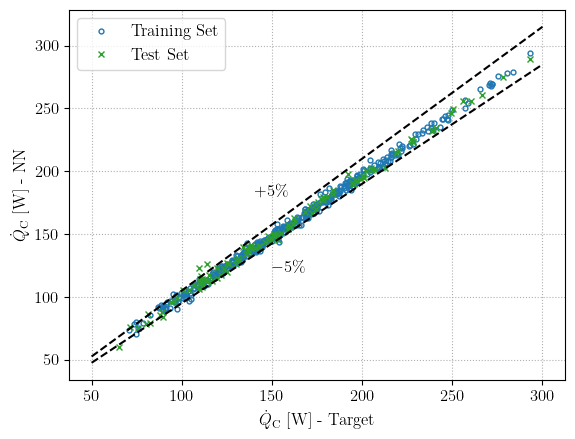

In [20]:
Test(X_train,y_train,'Qc',Scaller)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 8)                 32        
_________________________________________________________________
dense (Dense)                (None, 295)               2655      
_________________________________________________________________
batch_normalization_1 (Batch (None, 295)               1180      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 296       
Total params: 4,163
Trainable params: 3,557
Non-trainable params: 606
_________________________________________________________________
The coefficient of determination for Wm Training Set using Neural Networks is 0.9971362917225965
The coefficient of determination for Wm Test Set using Neural Networks is 0.9960407107071586


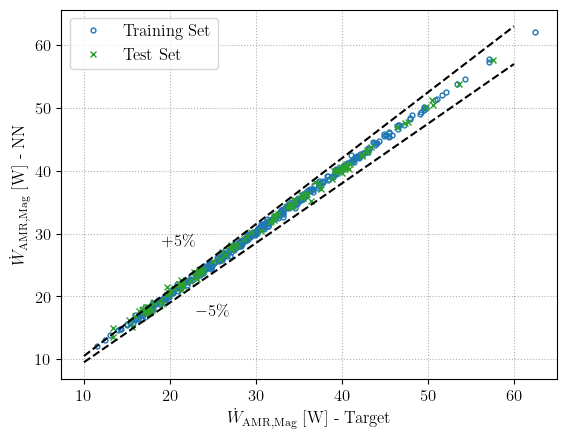

In [21]:
Test(X_train,y_train,'Wm',Scaller)